In [1]:

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2024-03-19 05:48:42--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.181.207, 64.233.182.207, 64.233.183.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.181.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  78.3MB/s    in 0.8s    

2024-03-19 05:48:43 (78.3 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib.pyplot as plt

In [3]:
local_zip = '/tmp/image_dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/image_dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_original_dir = os.path.join(train_dir, 'original')

# Directory with our training dog pictures
train_tampered_dir = os.path.join(train_dir, 'tampered')

# Directory with our validation cat pictures
validation_original_dir = os.path.join(validation_dir, 'original')

# Directory with our validation dog pictures
validation_tampered_dir = os.path.join(validation_dir, 'tampered')

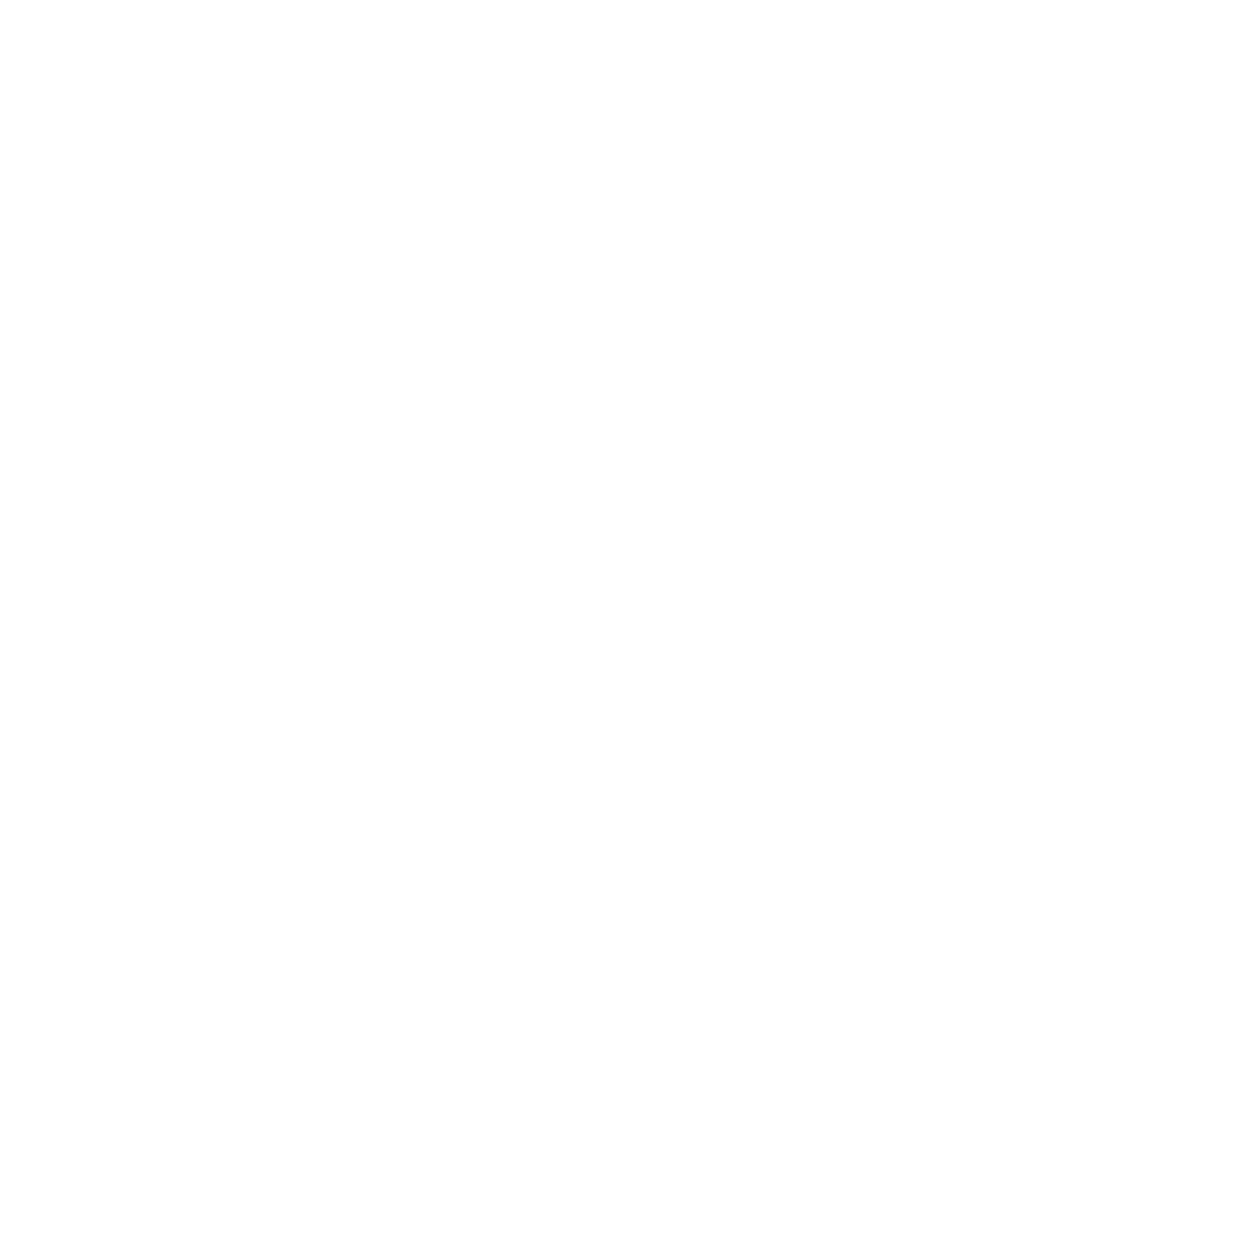

In [4]:
# Set up matplotlib fig, and size it to fit 4x4 pics
import matplotlib.image as mpimg
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 100
train_original_fnames = os.listdir( train_original_dir )
train_tampered_fnames = os.listdir( train_tampered_dir )


next_original_pix = [os.path.join(train_original_dir, fname)
                for fname in train_original_fnames[ pic_index-8:pic_index]
               ]

next_tampered_pix = [os.path.join(train_tampered_dir, fname)
                for fname in train_tampered_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_original_pix+next_tampered_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)

In [ ]:
!pip install -U efficientnet

In [ ]:
import efficientnet.keras as efn

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

validation_generator = test_datagen.flow_from_directory( validation_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
base_model = efn.EfficientNetB0(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Dropout
from keras import optimizers
from keras.optimizers import RMSprop
from tensorflow.keras.optimizers import RMSprop as legacy_RMSprop

In [ ]:
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
predictions = Dense(1, activation="sigmoid")(x)
model_final = Model(inputs = base_model.input, outputs = predictions)

In [ ]:
model_final.compile(optimizer=RMSprop(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
eff_history = model_final.fit_generator(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)

<ipython-input-36-5e73dccce911>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  eff_history = model_final.fit_generator(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)


Epoch 1/10
100/100 [==============================] - 37s 306ms/step - loss: 2.6303 - accuracy: 0.8765 - val_loss: 0.2733 - val_accuracy: 0.9740
Epoch 2/10
100/100 [==============================] - 32s 318ms/step - loss: 1.1137 - accuracy: 0.9165 - val_loss: 0.3281 - val_accuracy: 0.9790
Epoch 3/10
100/100 [==============================] - 29s 292ms/step - loss: 1.0338 - accuracy: 0.9310 - val_loss: 0.5178 - val_accuracy: 0.9780
Epoch 4/10
100/100 [==============================] - 31s 307ms/step - loss: 0.7359 - accuracy: 0.9420 - val_loss: 0.3418 - val_accuracy: 0.9810
Epoch 5/10
100/100 [==============================] - 29s 293ms/step - loss: 0.7936 - accuracy: 0.9325 - val_loss: 0.2402 - val_accuracy: 0.9760
Epoch 6/10
100/100 [==============================] - 30s 301ms/step - loss: 0.6536 - accuracy: 0.9375 - val_loss: 0.2926 - val_accuracy: 0.9770
Epoch 7/10
100/100 [==============================] - 29s 294ms/step - loss: 0.5319 - accuracy: 0.9420 - val_loss: 0.2356 - val_ac

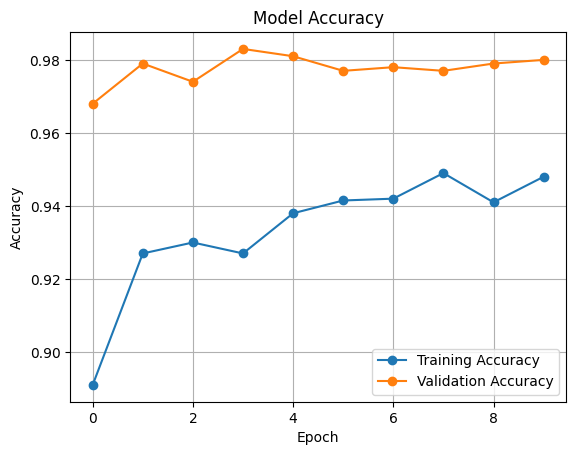

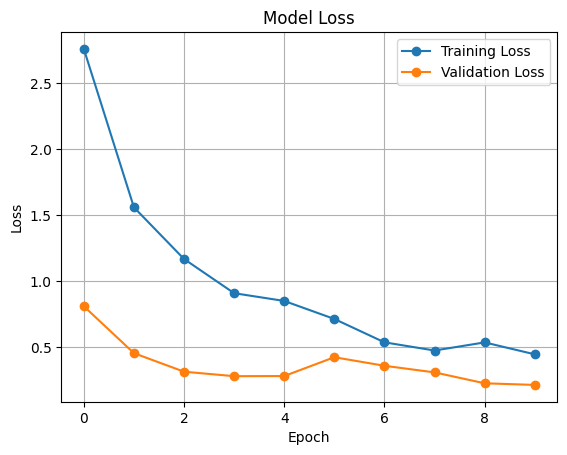

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have already trained your model and stored the history object in eff_history

# Plotting the training and validation accuracy
plt.plot(eff_history.history['accuracy'], marker='o', label='Training Accuracy')
plt.plot(eff_history.history['val_accuracy'], marker='o', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

# Plotting the training and validation loss
plt.plot(eff_history.history['loss'], marker='o', label='Training Loss')
plt.plot(eff_history.history['val_loss'], marker='o', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()



### **VGG**

In [ ]:

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )


In [ ]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory( validation_dir,  batch_size = 20, class_mode = 'binary', target_size = (224, 224))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False


In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])


In [ ]:
vgghist = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)

Epoch 1/10
100/100 [==============================] - 38s 324ms/step - loss: 1.8260 - acc: 0.6385 - val_loss: 0.3986 - val_acc: 0.8130
Epoch 2/10
100/100 [==============================] - 33s 326ms/step - loss: 0.5336 - acc: 0.7460 - val_loss: 0.5689 - val_acc: 0.6800
Epoch 3/10
100/100 [==============================] - 32s 319ms/step - loss: 0.5039 - acc: 0.7530 - val_loss: 0.2679 - val_acc: 0.8890
Epoch 4/10
100/100 [==============================] - 32s 318ms/step - loss: 0.4415 - acc: 0.7940 - val_loss: 0.2419 - val_acc: 0.9040
Epoch 5/10
100/100 [==============================] - 32s 318ms/step - loss: 0.4103 - acc: 0.8220 - val_loss: 0.3063 - val_acc: 0.8550
Epoch 6/10
100/100 [==============================] - 32s 322ms/step - loss: 0.3777 - acc: 0.8275 - val_loss: 0.2183 - val_acc: 0.9200
Epoch 7/10
100/100 [==============================] - 32s 323ms/step - loss: 0.3775 - acc: 0.8355 - val_loss: 0.3226 - val_acc: 0.8720
Epoch 8/10
100/100 [==============================] - 3

In [ ]:
print(vgghist.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


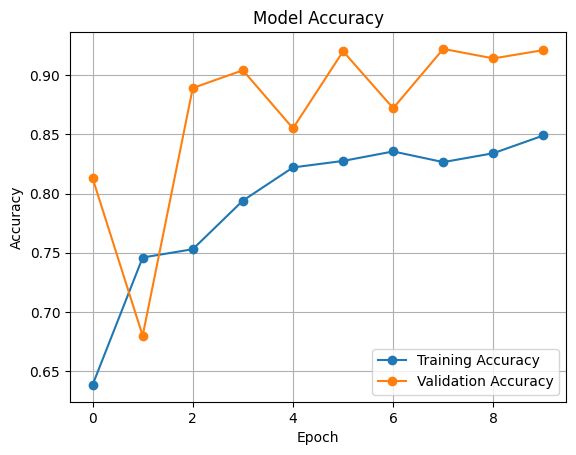

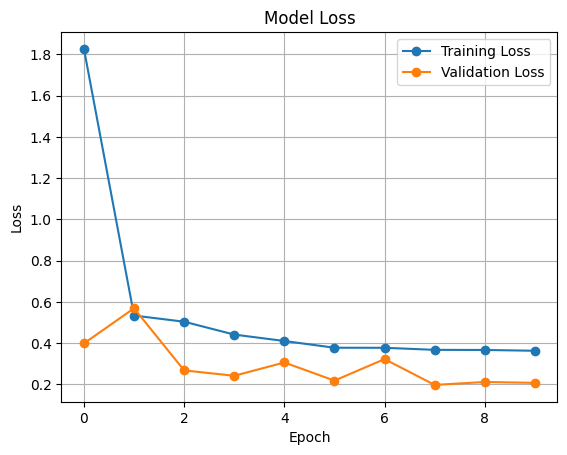

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have already trained your model and stored the history object in eff_history

# Plotting the training and validation accuracy
plt.plot(vgghist.history['acc'], marker='o', label='Training Accuracy')
plt.plot(vgghist.history['val_acc'], marker='o', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

# Plotting the training and validation loss
plt.plot(vgghist.history['loss'], marker='o', label='Training Loss')
plt.plot(vgghist.history['val_loss'], marker='o', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()
